<h1>Variational Auto-encoded Regression</h1>

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
import torch.utils as utils
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.datasets as dsets
from torch.utils.data import Dataset, DataLoader
from torchvision import models
MVN = torch.distributions.MultivariateNormal

import gpytorch

import cv2
from skimage import io

import matplotlib.pyplot as plt

import time
import copy
import random as rd
import numpy.random as nprd
import collections
import sys
import os
os.chdir("/mnt/juhyeong/projects/2019연구학점제/")
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

#codes.py
sys.path.insert(0, '../')
import codes

device = torch.device('cuda')

In [3]:
rd.seed(0)
class adobe240fps(Dataset):
    def __init__(self, train = True):
        self.data_dir = "/mnt/ssd0/data/adobe240fps/"
        self.folder_list = sorted(os.listdir(self.data_dir))
        self.video_len = len(self.folder_list)
        self.ToTensor = transforms.ToTensor()
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((256, 256))
        ])
        
        test_split = nprd.choice(self.video_len, int(self.video_len * 0.2), replace=False)

        if train:
            self.data_src = [self.folder_list[x] for x in range(self.video_len) if x not in test_split]
        else:
            self.data_src = [self.folder_list[x] for x in range(self.video_len) if x in test_split]

        self.data = []
        for src in self.data_src:
            frames = sorted(os.listdir(self.data_dir + src + "/240/" + src + "/"))
            len_frames = len(frames)
            frames = frames[:((len_frames - 1) // 8) * 8 + 1]
            for ind in range((len_frames - 1) // 8):
                self.data.append([self.data_dir + src + "/240/" + src +"/" + x for x in frames[ind * 8:ind * 8 + 9]])

        self.len = len(self.data)        

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        imgs = [cv2.imread(x) for x in self.data[idx]]
        if imgs[0].shape[0] < imgs[0].shape[1]:
            imgs = [x.transpose(1, 0, 2) for x in imgs]
        
        imgs = [self.transform(x) for x in imgs]
        
        if rd.random() > 0.5:
            imgs = [TF.hflip(x) for x in imgs]
        if rd.random() > 0.5:
            imgs = [TF.vflip(x) for x in imgs]
        imgs = torch.cat([self.ToTensor(x).unsqueeze(0) for x in imgs], 0)
        #return torch.stack((imgs[0], imgs[8])), imgs
        return imgs
    
    

class adobe240fps_one_video(Dataset):
    def __init__(self, train = True, one_video = False):
        self.data_dir = "/mnt/ssd0/data/adobe240fps/"
        self.folder_list = sorted(os.listdir(self.data_dir))
        self.video_len = len(self.folder_list)
        self.ToTensor = transforms.ToTensor()
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((256, 256))
        ])

        src = self.folder_list[nprd.randint(self.video_len, size = 1)[0]]
        self.data_src = os.listdir(self.data_dir + src + "/240/" + src + "/")

        self.data = [self.data_dir + src + "/240/" + src + "/" + x for x in sorted(os.listdir(self.data_dir + src + "/240/" + src + "/"))]
        self.total_len = len(self.data)

        test_split = nprd.choice(len(self.data), int(len(self.data) * 0.2), replace=False)

        if train:
            self.data = [self.data[x] for x in range(len(self.data)) if x not in test_split]
        else:
            self.data = [self.data[x] for x in range(len(self.data)) if x in test_split]

        self.len = len(self.data)
        
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        img = cv2.imread(self.data[idx])
        if img[0].shape[0] < img[0].shape[1]:
            img = img.transpose(1, 0, 2)
        
        img = self.transform(img)
        
        if rd.random() > 0.5:
            img = TF.hflip(img)
        if rd.random() > 0.5:
            img = TF.vflip(img)
        
        file_name = self.data[idx]
        file_name = int(file_name[file_name.rfind("/") + 1:file_name.rfind(".")])
        
        return self.ToTensor(img), file_name


    
    
class vimeo90k(Dataset):
    def __init__(self):
        self.data_dir = "/juhyeong/data/vimeo90k/vimeo_triplet/"
        self.folder_list = os.listdir()
    
    def __len__(self):
        pass
        
    def __getitem__(self):
        pass

In [4]:
train = adobe240fps(train=True)
print(train[0].shape)
train_one = adobe240fps_one_video(train=True)
print(train_one[0][0].shape)

torch.Size([9, 3, 256, 256])
torch.Size([3, 256, 256])


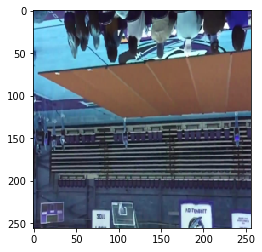

In [5]:
plt.imshow(train[0][0].transpose(0,2).numpy())
plt.show()

In [6]:
batch_size = 16
train_loader = DataLoader(dataset = adobe240fps(train=True),
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)
test_loader = DataLoader(dataset = adobe240fps(train=False),
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)

In [7]:
for img in train_loader:
    break

In [8]:
train_loader_one_video = DataLoader(dataset = adobe240fps_one_video(train=True),
                          batch_size=32,
                          shuffle=True,
                          num_workers=0)
test_loader_one_video = DataLoader(dataset = adobe240fps_one_video(train=False),
                          batch_size=32,
                          shuffle=True,
                          num_workers=0)

In [9]:
class VAE(nn.Module):
    def __init__(self, latent_dim=64, if_device = False):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.if_device = if_device
        
        #####Encoder
        self.encoder = nn.Sequential(            
            nn.Conv2d(3, 4, kernel_size = 4, stride = 3, bias = False),
            nn.BatchNorm2d(4),
            nn.LeakyReLU(0.1),
            # 4 x 85 x 85
            
            nn.Conv2d(4, 8, kernel_size = 4, stride = 3, bias = False),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(0.1),
            # 8 x 28 x 28
            
            nn.Conv2d(8, 16, kernel_size = 4, stride = 3, bias = False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1),
            # 16 x 9 x 9
            
            nn.Conv2d(16, 32, kernel_size = 3, stride = 2, bias = False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            # 32 x 4 x 4
            
            nn.Conv2d(32, 32, kernel_size = 3, bias = False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            # 32 x 2 x 2
            
            nn.Conv2d(32, 64, kernel_size = 2, bias = False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            # 32 x 1 x 1
            
            codes.Flatten()
        )
        
        
        
        # Linear layers
        num_features = 64
        self.mean_z = nn.Linear(num_features, latent_dim, bias = True)
        self.logvar_z = nn.Linear(num_features, latent_dim, bias = True)

        #####Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, num_features, bias = True),
            
            codes.UnFlatten(64),
            
            nn.ConvTranspose2d(64, 32, kernel_size = 2, bias = False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            
            nn.ConvTranspose2d(32, 32, kernel_size = 3, bias = False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            
            nn.ConvTranspose2d(32, 16, kernel_size = 3, stride = 2, bias = False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1),
            
            nn.ConvTranspose2d(16, 8, kernel_size = 4, stride = 3, bias = False),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(0.1),
            
            nn.ConvTranspose2d(8, 4, kernel_size = 4, stride = 3, bias = False),
            nn.BatchNorm2d(4),
            nn.LeakyReLU(0.1),
            
            nn.ConvTranspose2d(4, 3, kernel_size = 4, stride = 3, bias = False),
            nn.BatchNorm2d(3),
            nn.LeakyReLU(0.1),
        )
        
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)
                
    def decode(self, x):
        print(x.shape)
        return self.decode(x.transpose(1, 2).view(-1, self.latent_dim))#.view(x.shape[0], x.shape[1], -1)
    
    def reparameterize(self, x):
        start = self.encoder(x[:,0,:,:,:])
        end = self.encoder(x[:,1,:,:,:])
        
        return self.mean_z(start), self.mean_z(end), self.logvar_z(start), self.logvar_z(end)
    
    
    def forward(self, x):
        mean_z_start, mean_z_end, logvar_z_start, logvar_z_end = self.reparameterize(x)
        var_z_start = logvar_z_start.mul(0.5).exp()
        var_z_end = logvar_z_end.mul(0.5).exp()
        
        if next(self.parameters()).is_cuda:
            latent_start = torch.randn(self.latent_dim).cuda().mul(var_z_start).add(mean_z_start)
            latent_end = torch.randn(self.latent_dim).cuda().mul(var_z_start).add(mean_z_start)
        else:
            latent_start = torch.randn(self.latent_dim).mul(var_z_start).add(mean_z_start)
            latent_end = torch.randn(self.latent_dim).mul(var_z_start).add(mean_z_start)

        return (torch.stack((self.decoder(latent_start), self.decoder(latent_end)), 1),
                torch.stack((mean_z_start, mean_z_end), 1),
                torch.stack((logvar_z_start, logvar_z_end), 1),
                torch.stack((latent_start, latent_end), 1))

In [10]:
model = VAE()
print(img.shape)
print(model.forward(img)[0].shape)
print([x.numel() for x in model.parameters()])
print(sum([x.numel() for x in model.parameters()]))

torch.Size([16, 9, 3, 256, 256])
torch.Size([16, 2, 3, 256, 256])
[192, 4, 4, 512, 8, 8, 2048, 16, 16, 4608, 32, 32, 9216, 32, 32, 8192, 64, 64, 4096, 64, 4096, 64, 4096, 64, 8192, 32, 32, 9216, 32, 32, 4608, 16, 16, 2048, 8, 8, 512, 4, 4, 192, 3, 3]
62518


<h1>Multi-output Gaussian Process</h1>

<h2>
Kernel function: $ k(\mathrm{x}_{n}, \mathrm{x}_{m}) = \theta_{0} \mathrm{exp}\left\{-{1 \over 2}\sum_{i=1}^D\eta_i(x_{n} - x_{m})^2\right\} + \theta_{2} + \theta_{3}\sum_{i=1}^Dx_{ni}x_{mi}  $

</h2>

In [11]:
class MOGP(nn.Module):
    def __init__(self, input_dim, output_dim, batch_size):
        super(MOGP, self).__init__()
        self.batch_size = batch_size
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_data = 0
        
        B = batch_size
        N = 0
        self.input_data = torch.empty(B, N, self.input_dim)
        self.output_data = torch.empty(B, N, self.output_dim)
        self.dot_prod = torch.empty(B, self.input_dim, N, N)
        self.dist = torch.empty(B, self.input_dim, N, N)
        
        self.ARD_params = nn.Parameter(torch.randn(self.input_dim, self.output_dim))
        self.kernel_params = nn.ParameterDict({
            "scale_ARD":nn.Parameter(torch.randn(output_dim)),
            "scale_prod":nn.Parameter(torch.randn(output_dim)),
            "constant":nn.Parameter(torch.randn(output_dim)),
        })
        self.noise_homo = nn.Parameter(torch.zeros(output_dim))

        
        
    def cal_stat(self):
        N = self.num_data
        D = self.input_dim
        B = self.batch_size
        data = self.input_data.transpose(1, 2)
        
        self.dot_prod = torch.einsum("bdm,bdn->bdmn", data, data)
        self.dist = ((data ** 2).unsqueeze(3).expand(B, D, N, N)
                     + (data ** 2).unsqueeze(2).expand(B, D, N, N)
                     - 2 * self.dot_prod)
        
        
    def kernel_fitted(self):
        self.cal_stat()
        gram = (-0.5 * torch.einsum("bdmn,do->bomn", self.dist, F.softplus(self.ARD_params))).exp()
        gram = torch.einsum("bdmn,d->bdmn", gram, F.softplus(self.kernel_params["scale_ARD"]))
        gram += torch.einsum("bmn,d->bdmn", self.dot_prod.sum(1), F.softplus(self.kernel_params["scale_prod"]))
        gram += F.softplus(self.kernel_params["constant"]).unsqueeze(1).unsqueeze(2)
        return gram
    
    
    def kernel_new(self, x):
        N = self.num_data
        D = self.input_dim
        M = x.shape[1]
        B = self.batch_size
        
        fitted_data = self.input_data.transpose(1, 2)
        new_data = x.transpose(1, 2)
        
        new_dot_prod_wing = torch.einsum("bdn,bdt->bdnt", fitted_data, new_data)
        new_dist_wing = ((fitted_data ** 2).unsqueeze(3).expand(B, D, N, M)
                     + (new_data ** 2).unsqueeze(2).expand(B, D, N, M)
                     - 2 * new_dot_prod_wing)
        
        wing = (-0.5 * torch.einsum("bdmn,do->bomn", new_dist_wing, F.softplus(self.ARD_params))).exp()
        wing = torch.einsum("bdmn,d->bdmn", wing, F.softplus(self.kernel_params["scale_ARD"]))
        wing += torch.einsum("bmn,d->bdmn", new_dot_prod_wing.sum(1), F.softplus(self.kernel_params["scale_prod"]))
        wing += F.softplus(self.kernel_params["constant"]).unsqueeze(1).unsqueeze(2)
        
        
        new_dot_prod_cov = torch.einsum("bdn,bdt->bdnt", new_data, new_data)
        new_dist_cov = ((new_data  ** 2).unsqueeze(3).expand(B, D, M, M)
                     + (new_data ** 2).unsqueeze(2).expand(B, D, M, M)
                     - 2 * new_dot_prod_cov)
        
        cov = (-0.5 * torch.einsum("bdmn,do->bomn", new_dist_cov, F.softplus(self.ARD_params))).exp()
        cov = torch.einsum("bdmn,d->bdmn", cov, F.softplus(self.kernel_params["scale_ARD"]))
        cov += torch.einsum("bmn,d->bdmn", new_dot_prod_cov.sum(1), F.softplus(self.kernel_params["scale_prod"]))
        cov += F.softplus(self.kernel_params["constant"]).unsqueeze(1).unsqueeze(2)
       
        return wing, cov
        
        
    def NLL(self):
        N = self.num_data
        B = self.batch_size

        self.train()
        gram = self.kernel_fitted()
        if next(self.parameters()).is_cuda:
            gram += torch.einsum("d,bmn->bdmn", F.softplus(self.noise_homo), torch.eye(N).cuda().expand(B, N, N))
        else:
            gram += torch.einsum("d,bmn->bdmn", F.softplus(self.noise_homo), torch.eye(N).expand(B, N, N))

        #Removed constant term from nll
        nll = torch.stack([x.squeeze().logdet() for x in gram.view(-1, gram.shape[2], gram.shape[3]).split(1,0)], 0).view(B, -1).sum(1)
        nll += torch.einsum("bmt,bdmn,bnt->bd", self.output_data, gram.inverse(), self.output_data).sum(1)
        nll *= 0.5
        return nll
    
    
    def fit(self, x, y):
        if next(self.parameters()).is_cuda:
            self.input_data = x.cuda()
            self.output_data = y.cuda()
        else:
            self.input_data = x
            self.output_data = y
        self.num_data = self.input_data.shape[1]

        
    def forward(self, x):
        self.eval()
        N = self.num_data
        B = self.batch_size
        gram = self.kernel_fitted()
        
        if next(self.parameters()).is_cuda:
            gram += torch.einsum("d,bmn->bdmn", F.softplus(self.noise_homo), torch.eye(N).cuda().expand(B, N, N))
            x = x.cuda()
        else:
            gram += torch.einsum("d,bmn->bdmn", F.softplus(self.noise_homo), torch.eye(N).expand(B, N, N))
            
        gram_inv = torch.cat([x.inverse() for x in gram.split(1,0)], 0)
        
        wing, cov = self.kernel_new(x)
        
        mean = torch.einsum("btnm,btnk,bkt->btm", wing, gram_inv, self.output_data)
        var = cov - torch.einsum("btnm,btnk,btkl->btml", wing, gram_inv, wing)
        return mean, var

In [12]:
GP_model = MOGP(input_dim = 32, output_dim = 50, batch_size = batch_size)
x = torch.randn(16, 100, 32)
GP_model.fit(x, torch.randn(16, 100, 50) * 0.01)
GP_model.cal_stat()
print(GP_model.dist.shape)
print(GP_model.kernel_fitted().shape)
for name, param in GP_model.named_parameters():
    if not param.requires_grad:
        print(f"{name} has no grad")
    
with torch.autograd.detect_anomaly():
    print(GP_model.NLL())
    GP_model.NLL().sum().backward()
    for name, param in GP_model.named_parameters():
        print(f"{name} = {param.grad.min()} ~ {param.grad.max()}")

x_new = torch.randn(16, 10, 32)
mean, var = GP_model(x_new)
print(mean.shape)
print(var.shape)

torch.Size([16, 32, 100, 100])
torch.Size([16, 50, 100, 100])
tensor([3951.4685, 3968.0061, 3942.0312, 3931.2256, 3934.6533, 3933.0823,
        3918.9099, 3934.6826, 3939.2278, 3941.7317, 3975.7673, 3936.0459,
        3919.4861, 3963.3428, 3946.0376, 3918.4880], grad_fn=<MulBackward0>)
ARD_params = 1.8116335922968574e-05 ~ 0.002694923896342516
noise_homo = 95.24468994140625 ~ 362.8816223144531
kernel_params.constant = 2.7356231212615967 ~ 6.591472625732422
kernel_params.scale_ARD = 34.89530563354492 ~ 218.5465545654297
kernel_params.scale_prod = 84.49845886230469 ~ 216.12376403808594
torch.Size([16, 50, 10])
torch.Size([16, 50, 10, 10])


In [13]:
GP_model = MOGP(input_dim = 1, output_dim = 64, batch_size = batch_size).cuda()
model = VAE().cuda()

In [14]:
epoch = 1000
lr = 3e-4
optimizer = torch.optim.Adam(list(model.parameters()) + list(GP_model.parameters()), lr = lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

In [15]:
def loss(recon, recon_gt, recon_new, recon_new_gt, mean, logvar, GP_model):
    # BCE = F.binary_cross_entropy(output, gt, reduction='sum')
    BCE = F.mse_loss(recon, recon_gt, reduction='mean')
    BCE_new = F.mse_loss(recon_new, recon_new_gt, reduction='mean')

    KLD = -0.25 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp()) 

    return BCE + BCE_new + KLD + GP_model.NLL(), BCE, BCE_new, KLD

In [16]:
def consistent_img(img):
    return torch.cat((img[:,0:1,:,:,:], img[:,-1:,:,:,:]), 1)

def consistent_label(x):
    return torch.stack((x[:,0], x[:,-1]), 1).unsqueeze(2)

def inconsistent_img(img):
    return img[:,1:-1,:,:,:]

def inconsistent_label(x):
    return x[:,1:-1].unsqueeze(2)

def new_latent(mean, logvar):
    return torch.randn(mean.shape).cuda().mul(logvar.exp()).add(mean)

In [17]:
running_test_loss = 0.0
label_base = (torch.arange(9, device = device).float() - 4)/4
label_base = label_base.unsqueeze(0).expand(16, 9)

for run in range(epoch):
    start = time.time()
    
    #Training
    model.train()
    batch_train_loss = 0.0
    scheduler.step()
    for ind, data in enumerate(train_loader):
        img = data
        label = label_base + torch.clamp(torch.randn(batch_size, 9, device = device) / 12, min = -0.25, max = 0.25)
        
        optimizer.zero_grad()
        recon, mean_z, logvar_z, latent = model(consistent_img(img).cuda())
        GP_model.fit(consistent_label(label).cuda(), latent)
        pred_mean, pred_var_cholesky = GP_model(inconsistent_label(label).cuda())
        recon_new = model.decode(torch.einsum("bdmn,bdn->bdm", pred_var_cholesky, torch.randn(batch_size, 64, 7, device=device)) + pred_mean)
        
        train_loss, BCE, BCE_new, KLD = loss(recon, consistent_img(img).cuda(), recon_new, inconsistent_img(img).cuda(), mean_z, logvar_z, GP_model)
        train_loss.backward()
        batch_train_loss += train_loss.item()
        optimizer.step()
        
    batch_train_loss /= len(train_loader)

    #Test
    model.eval()
    with torch.no_grad():
        batch_test_loss = 0.0
        for ind, data in enumerate(test_loader):
            img = data
            label = label_base + torch.clamp(torch.randn(batch_size, 9) / 12, min = -0.25, max = 0.25)
        
            optimizer.zero_grad()
            recon, mean_z, logvar_z, latent = model(consistent_img(img).cuda())
            pred_mean, pred_var_cholesky = GP_model(inconsistent_label(label).cuda())
            recon_new = model.decode(torch.einsum("bdmn,bdn->bdm", pred_var_cholesky, torch.randn(batch_size, 64, 7, device=device)) + pred_mean)
            train_loss, BCE, BCE_new, KLD = loss(recon, consistent_img(img).cuda(), recon_new, inconsistent_img(img).cuda(), mean_z, logvar_z, GP_model)
            
        batch_test_loss /= len(test_loader)
        running_test_loss += test_loss.item()
        
    print("epoch : %d, train loss = %5.5f, test loss = %5.5f, running test loss = %5.5f, time: %.2f sec"
          %(run, batch_train_loss, batch_test_loss, running_test_loss/(run + 1), time.time() - start))

torch.Size([16, 64, 7])


RuntimeError: invalid argument 2: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Call .contiguous() before .view(). at /pytorch/aten/src/THC/generic/THCTensor.cpp:209

<h1>NP</h1>

In [ ]:
class NP(nn.Module):
    def __init__(self, latent_dim = 100):
        super(NP, self).__init__()
        self.encoder_x = nn.Sequential(
            nn.BatchNorm1d(1)
        )
        self.encoder_y = nn.Sequential(
            nn.Conv2d(3, 4, kernel_size = 4, stride = 3, bias = False),
            nn.BatchNorm2d(4),
            nn.LeakyReLU(0.1),
            # 4 x 85 x 85
            
            nn.Conv2d(4, 8, kernel_size = 4, stride = 3, bias = False),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(0.1),
            # 8 x 28 x 28
            
            nn.Conv2d(8, 16, kernel_size = 4, stride = 3, bias = False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1),
            # 16 x 9 x 9
            
            nn.Conv2d(16, 32, kernel_size = 3, stride = 2, bias = False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            # 32 x 4 x 4

            nn.AdaptiveAvgPool2d((1, 1))
            # 32 x 1 x 1
            
            codes.Flatten()
        )
        
        
        
    def kernel(self, x, y):
        return 
    
    def fit(self, x, y):
        
        
    def forward(self, x):
        rep = torch.stack((self.encoder_x(x), self.encoder_y(x)), 0).mean(0)
        

In [ ]:
epoch = 1000
lr = 3e-4
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

In [25]:
def ELBO(output, gt, mean, logvar):
    # BCE = F.binary_cross_entropy(output, gt, reduction='sum')
    BCE = F.mse_loss(output, gt, reduction='sum')

    KLD = -0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

In [22]:
running_test_loss = 0.0
for run in range(epoch):
    start = time.time()
    
    #Training
    model.train()
    train_loss = 0.0
    scheduler.step()
    for ind, data in enumerate(train_loader_one_video):
        img, label = data
        optimizer.zero_grad()
        output, mean_z, logvar_z, lognoise_x, lognoise_z = model(img.cuda())
        loss, BCE, KLD = ELBO(output, img.cuda(), mean_z, logvar_z)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    train_loss /= len(train_loader_one_video)
    
    #Test
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        for ind, data in enumerate(test_loader_one_video):
            img, label = data
            output, mean_z, logvar_z, lognoise_x, lognoise_z = model(img.cuda())
            loss, BCE, KLD = ELBO(output, img.cuda(), mean_z, logvar_z)
            test_loss += loss
        test_loss /= len(test_loader_one_video)
        running_test_loss += test_loss.item()
    print("epoch : %d, train loss = %5.5f, test loss = %5.5f, running test loss = %5.5f, time: %.2f sec"
          %(run, train_loss, test_loss, running_test_loss/(run + 1), time.time() - start))

epoch : 0, train loss = 2890394.93040, test loss = 2520966.25000, running test loss = 2520966.25000, time: 53.21 sec
epoch : 1, train loss = 1989401.32422, test loss = 1305214.62500, running test loss = 1913090.43750, time: 53.14 sec
epoch : 2, train loss = 1512514.19460, test loss = 935464.00000, running test loss = 1587214.95833, time: 53.07 sec
epoch : 3, train loss = 1233105.79048, test loss = 853043.00000, running test loss = 1403671.96875, time: 53.02 sec
epoch : 4, train loss = 1066336.48420, test loss = 810716.12500, running test loss = 1285080.80000, time: 53.04 sec
epoch : 5, train loss = 955982.61985, test loss = 822577.81250, running test loss = 1207996.96875, time: 53.14 sec
epoch : 6, train loss = 884631.80149, test loss = 838703.56250, running test loss = 1155240.76786, time: 53.18 sec
epoch : 7, train loss = 826693.27433, test loss = 845089.12500, running test loss = 1116471.81250, time: 53.18 sec
epoch : 8, train loss = 779974.63104, test loss = 876085.50000, running t

KeyboardInterrupt: 

In [22]:
running_test_loss = 0.0
for run in range(epoch):
    start = time.time()
    
    #Training
    model.train()
    train_loss = 0.0
    scheduler.step()
    for ind, data in enumerate(train_loader):
        img, label = data
        optimizer.zero_grad()
        output, mean_z, logvar_z, lognoise_x, lognoise_z = model(img.cuda())
        loss, BCE, KLD = ELBO(output, img.cuda(), mean_z, logvar_z)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    train_loss /= len(train_loader)
    
    #Test
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        for ind, data in enumerate(test_loader):
            img, label = data
            output, mean_z, logvar_z, lognoise_x, lognoise_z = model(img.cuda())
            loss, BCE, KLD = ELBO(output, img.cuda(), mean_z, logvar_z)
            test_loss += loss
        test_loss /= len(test_loader)
        running_test_loss += test_loss.item()
    print("epoch : %d, train loss = %5.5f, test loss = %5.5f, running test loss = %5.5f, time: %.2f sec"
          %(run, train_loss, test_loss, running_test_loss/(run + 1), time.time() - start))

epoch : 0, train loss = 2890394.93040, test loss = 2520966.25000, running test loss = 2520966.25000, time: 53.21 sec
epoch : 1, train loss = 1989401.32422, test loss = 1305214.62500, running test loss = 1913090.43750, time: 53.14 sec
epoch : 2, train loss = 1512514.19460, test loss = 935464.00000, running test loss = 1587214.95833, time: 53.07 sec
epoch : 3, train loss = 1233105.79048, test loss = 853043.00000, running test loss = 1403671.96875, time: 53.02 sec
epoch : 4, train loss = 1066336.48420, test loss = 810716.12500, running test loss = 1285080.80000, time: 53.04 sec
epoch : 5, train loss = 955982.61985, test loss = 822577.81250, running test loss = 1207996.96875, time: 53.14 sec
epoch : 6, train loss = 884631.80149, test loss = 838703.56250, running test loss = 1155240.76786, time: 53.18 sec
epoch : 7, train loss = 826693.27433, test loss = 845089.12500, running test loss = 1116471.81250, time: 53.18 sec
epoch : 8, train loss = 779974.63104, test loss = 876085.50000, running t

KeyboardInterrupt: 

In [ ]:
class GP(nn.Module):
    def __init__(self):
        super(GP, self).__init__()
        self.layers = nn.Sequential

In [ ]:
## class VAE(nn.Module):
    def __init__(self, growth_rate=32, block_config=[3, 4],
                 num_init_input=64, num_init_hidden=128, bn_size=4, drop_rate=0, latent_dim=1000):
        super(VAE, self).__init__()
        self.normal = torch.distributions.MultivariateNormal(torch.zeros(latent_dim), torch.eye(latent_dim))
        
        #####Encoder
        self.encoder = nn.Sequential(collections.OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_input, kernel_size=7, stride=2, padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_input)),
            ('relu0', nn.LeakyReLU(0.1)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))
        
        #Each denseblock
        num_features = num_init_input
        for i, num_layers in enumerate(block_config):
            block = codes.DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=False
            )
            self.encoder.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = codes.TransitionDown(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.encoder.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2
                
        # Final batch norm
        self.encoder.add_module('norm5', nn.BatchNorm2d(num_features))
        
        # Linear layers
        self.mean_z = nn.Linear(num_features, latent_dim)
        self.logvar_z = nn.Linear(num_features, latent_dim)
        
        self.noise_x = nn.Linear(num_features, 1)
        self.noise_z = nn.Linear(num_features, 1)
        
        
        
        #####Decoder
        self.decoder = nn.Sequential(collections.OrderedDict([
            ()
            
        ]))
        self.decoder.add_module('norm5', nn.BatchNorm2d(num_features))
        #Each denseblock
        num_features = num_init_hidden
        block_config.reverse()
        for i, num_layers in enumerate(block_config):
            block = codes.DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=False
            )
            self.decoder.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = codes.TransitionUp(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.decoder.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2
                
        # Final branch norm
        self.decoder.add_module = nn.Sequential(collections.OrderedDict([
            ('conv0', nn.Conv2d(latent_dim, num_init_hidden, kernel_size=7, stride=2, padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_hidden)),
            ('relu0', nn.LeakyReLU(0.1)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))
     
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)
    
    def reparameterize(self, x):
        x = self.encoder(x)
        x = F.relu(x, inplace=True)
        out = F.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), -1)
        return self.mean_z(out), self.logvar_z(out).exp(), self.noise_x(out).exp(), self.noise_z(out).exp()
    
    def forward(self, x):
        mean_z, var_z, noise_x, noise_z = self.reparameterize(x)
        return self.decoder(self.normal.sample() * var_z + mean_z), mean_z, var_z, noise_x , noise_z
        
model = VAE()